# MultiLinear regression models

## Linear regression theory

We assume here that $ y | X ; \theta\sim\mathcal{N}(\mu,\sigma ^2)$ !!

* **Normal equations** - By noting $X$ the design matrix, the value of $\theta$ that minimizes the cost function is a closed-form solution such that:

$$
\boxed{\theta=(X^TX)^{-1}X^Ty}
$$

Below, a sketch of how a linear regression model can be is seen:

```{figure} ../media/images/linear-model.png
---
width: 550px
name: linearmodel-sketch
---
This is a sketch of a linear model, where just one independent variable predicts the target variable Y, based on the [Least squares method](https://en.wikipedia.org/wiki/Least_squares)
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
import sys, os
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss/')
data_path = '/Users/administrador/Documents/geocean-nz-ss/data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, \
    default_evaluation_metrics, default_location
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.utils import calculate_relative_winds
from sscode.pca import PCA_DynamicPred
from sscode.linear import MultiLinear_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DATA PATH /Users/administrador/Documents/geocean-nz-ss/data/


## Load the data

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

In [2]:
# load the data using the Loader class
load_cfsr_moana_uhslc = Loader(
    data_to_load=('cfsr','moana','uhslc'),
    time_resample='1D',load_winds=(True,None),
    plot=(False,False,False),
    load_predictor_files=(True,(os.environ['SSURGE_DATA_PATH']+'cfsr/CFSR_MSLP_daily.nc',
                                os.environ['SSURGE_DATA_PATH']+'cfsr/CFSR_WINDs_daily.nc'))
)


 loading previously saved atmospheric data from (True, ('/Users/administrador/Documents/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/Users/administrador/Documents/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc')) 


 loading the Moana v2 hindcast data... 


 loading the UHSLC tidal guages... 



## Calculate regional PCA

Now, with the loaded data, we can calculate the regional PCs, so they can be used to reconstruct the storm surge all over New Zealand, using the same atmospheric predictor.

/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/ ['default_region_reduced', 'no_winds', 'gradients', '1D', 'tl1']
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/default_region_reduced_no_winds_gradients_1D_tl1.nc
Assembling matrix

 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 45, 51) 


 pcs_matrix with shape: 
 (11353, 4590) 


 calculating PCs matrix with shape: 
 (11353, 4590) 

Computing using CPU
matrix (11353, 4590)
PCs (11353, 62)
comp (62, 4590)
var (62,)
lon <xarray.DataArray 'longitude' (longitude: 51)>
array([160. , 160.5, 161. , 161.5, 162. , 162.5, 163. , 163.5, 164. , 164.5,
       165. , 165.5, 166. , 166.5, 167. , 167.5, 168. , 168.5, 169. , 169.5,
       170. , 170.5, 171. , 171.5, 172. , 172.5, 173. , 173.5, 174. , 174.5,
       175. , 175.5, 176. , 176.5, 177. , 177.5, 178. , 178.5, 179. , 179.5,
       180. , 180.5, 181. , 181.5, 182. , 182.5, 183. , 1

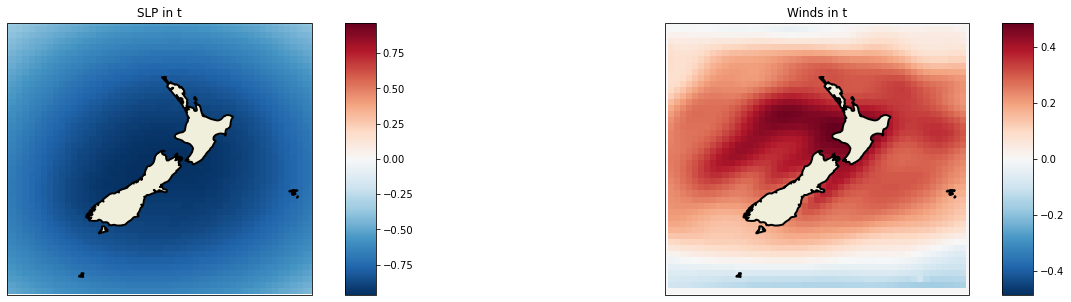

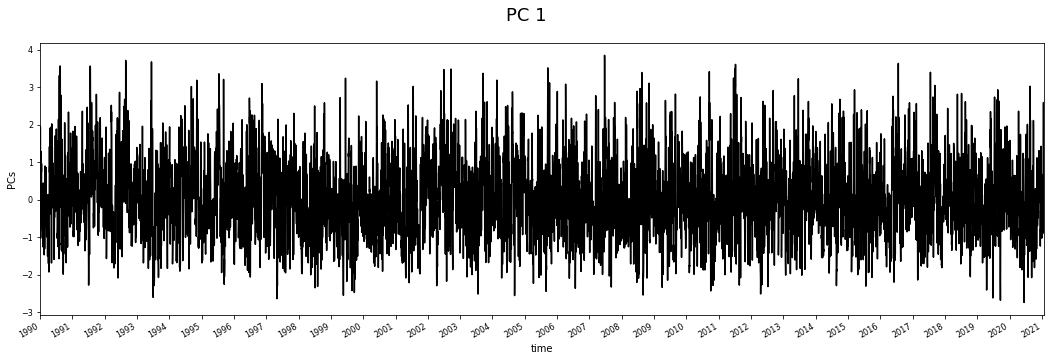

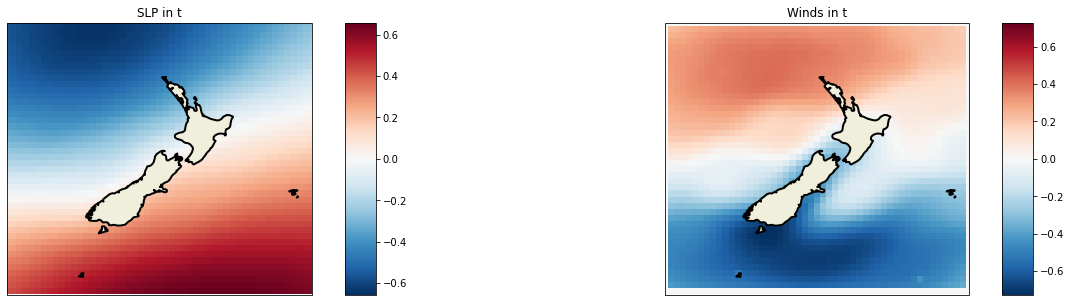

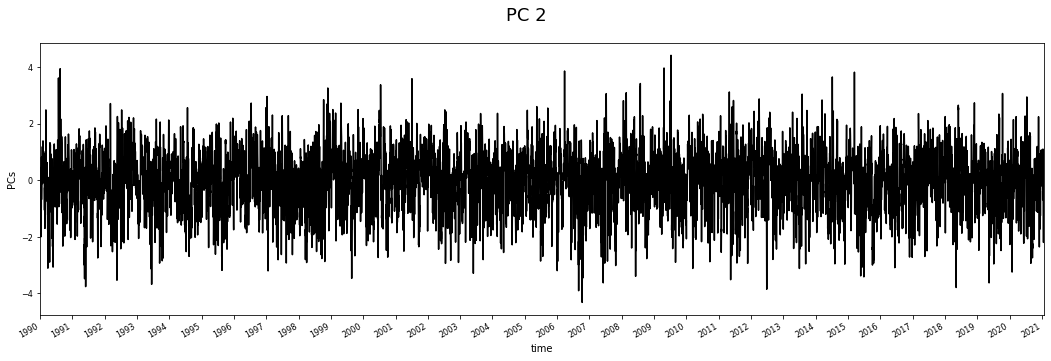

In [7]:
pcs_data_regional, pcs_scaler_regional = PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp.SLP, 
    calculate_gradient=True,
    wind=None,
    time_lapse=1, # 1 equals to NO time delay                    
    time_resample='1D', # daily resampling
    region=(True,default_region_reduced),
    site_location=default_location,
    pca_plot=(True,False,2),
    pca_ttls=('SLP in t','Winds in t'),
    pcs_folder='/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/'
).pcs_get() # look the simplicity of the function

## Linear regression with regional predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics/linear` folder, with the name `stats_lm_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

  0% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 26 PCs (0.95 expl. variance) will be used to train the model!! 



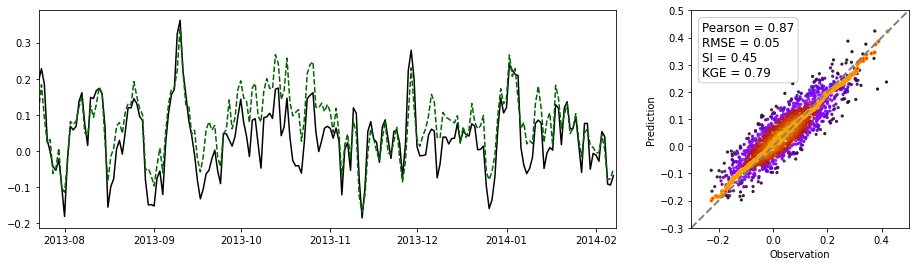

  6% (1 of 15) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:06

Data comparison is   --   BIAS: -0.01, SI: 0.45, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.75701088], KGE = [0.7851156] and KGE_PRIME = [0.71523469]
 R score: 0.76 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



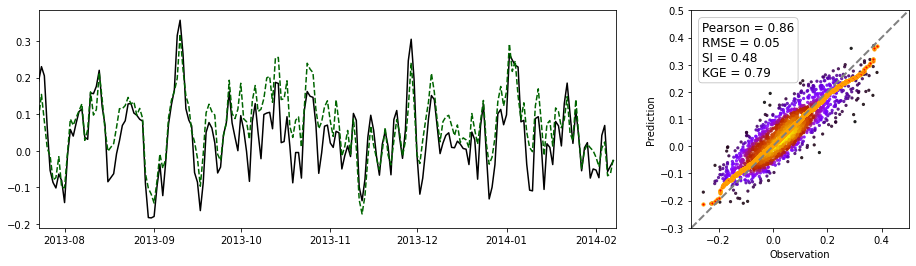

 13% (2 of 15) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:06

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73793031], KGE = [0.79085764] and KGE_PRIME = [0.73748864]
 R score: 0.74 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



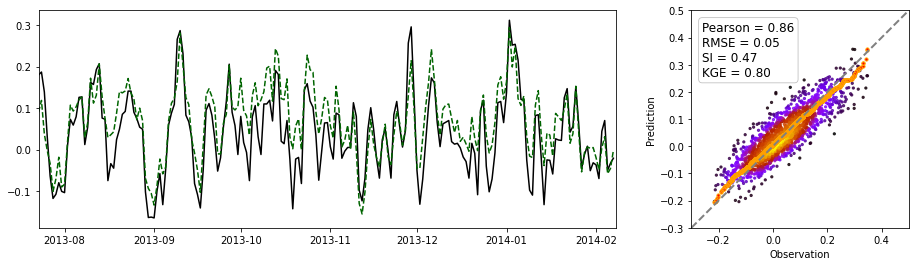

 20% (3 of 15) |#####                    | Elapsed Time: 0:00:01 ETA:   0:00:05

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.74414972], KGE = [0.79558384] and KGE_PRIME = [0.73946609]
 R score: 0.74 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



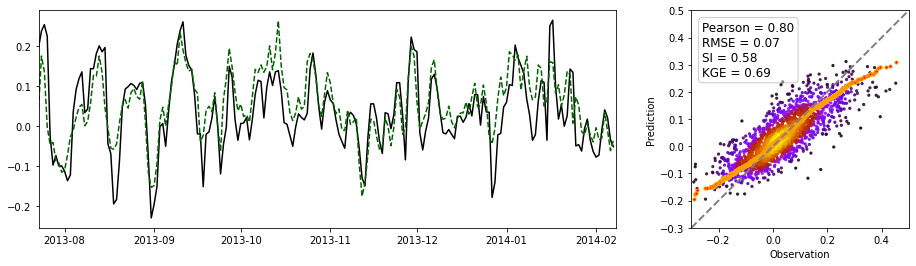

 26% (4 of 15) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:05

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 NSE = [0.63203387], KGE = [0.69414078] and KGE_PRIME = [0.64686528]
 R score: 0.63 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



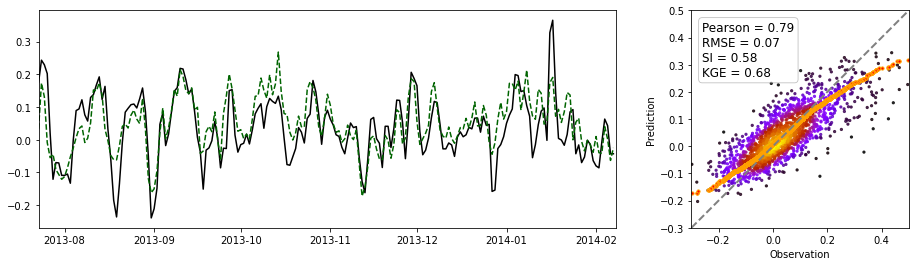

 33% (5 of 15) |########                 | Elapsed Time: 0:00:02 ETA:   0:00:04

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.79, 0.63)
 NSE = [0.62558699], KGE = [0.6805487] and KGE_PRIME = [0.65677772]
 R score: 0.63 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



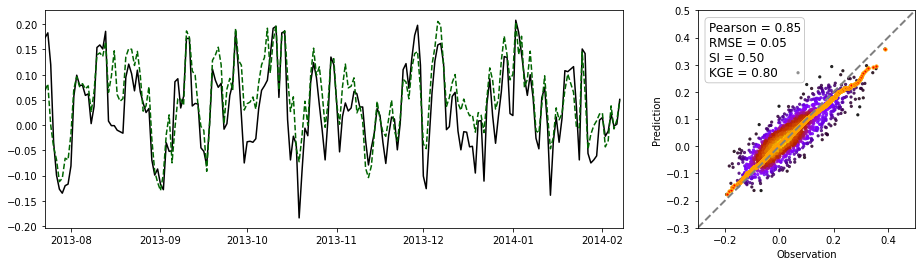

 40% (6 of 15) |##########               | Elapsed Time: 0:00:03 ETA:   0:00:04

Data comparison is   --   BIAS: -0.00, SI: 0.50, Relative - RMSE: 0.24
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.71959023], KGE = [0.79826116] and KGE_PRIME = [0.76085212]
 R score: 0.72 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



 46% (7 of 15) |###########              | Elapsed Time: 0:00:03 ETA:   0:00:04

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 NSE = [0.70467653], KGE = [0.78199003] and KGE_PRIME = [0.76069203]
 R score: 0.7 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



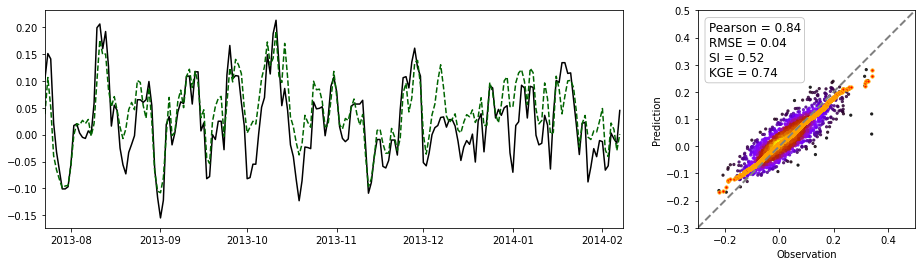

 53% (8 of 15) |#############            | Elapsed Time: 0:00:04 ETA:   0:00:03

Data comparison is   --   BIAS: -0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 NSE = [0.70722239], KGE = [0.74267561] and KGE_PRIME = [0.6785094]
 R score: 0.71 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



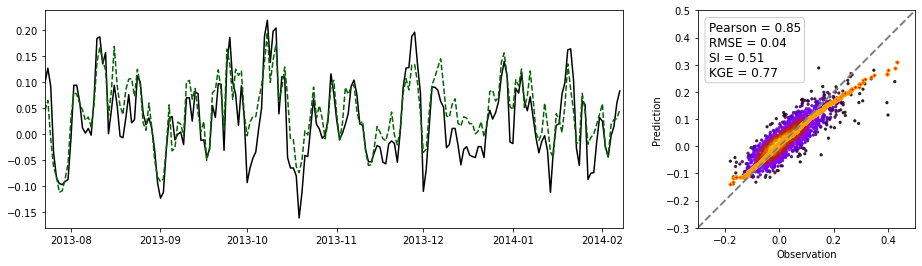

 60% (9 of 15) |###############          | Elapsed Time: 0:00:04 ETA:   0:00:03

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.71)
 NSE = [0.71394509], KGE = [0.76882925] and KGE_PRIME = [0.74839808]
 R score: 0.71 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



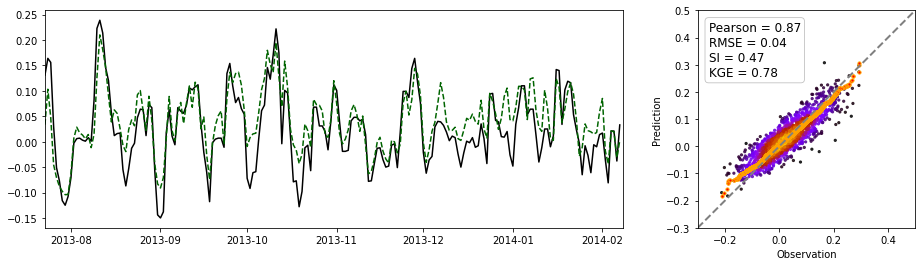

 66% (10 of 15) |################        | Elapsed Time: 0:00:05 ETA:   0:00:03

Data comparison is   --   BIAS: -0.00, SI: 0.47, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.87, 0.76)
 NSE = [0.75619241], KGE = [0.77957818] and KGE_PRIME = [0.71731304]
 R score: 0.76 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



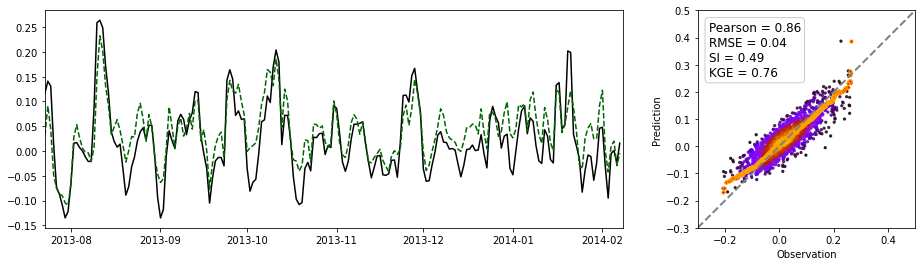

 73% (11 of 15) |#################       | Elapsed Time: 0:00:06 ETA:   0:00:02

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 NSE = [0.73587428], KGE = [0.7552107] and KGE_PRIME = [0.68372388]
 R score: 0.74 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



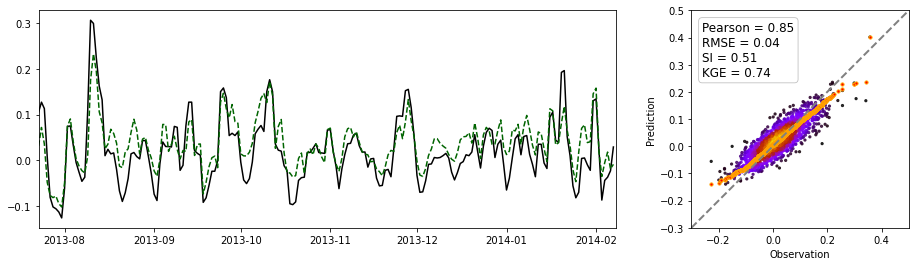

 80% (12 of 15) |###################     | Elapsed Time: 0:00:06 ETA:   0:00:01

Data comparison is   --   BIAS: -0.00, SI: 0.51, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 NSE = [0.7185531], KGE = [0.73986864] and KGE_PRIME = [0.67264339]
 R score: 0.72 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



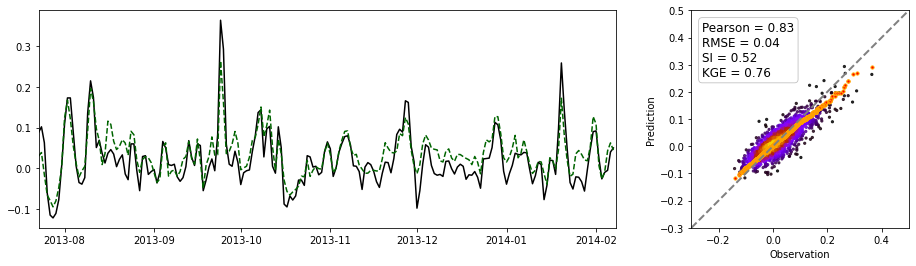

 86% (13 of 15) |####################    | Elapsed Time: 0:00:07 ETA:   0:00:01

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.83, 0.70)
 NSE = [0.69684824], KGE = [0.76335421] and KGE_PRIME = [0.77029932]
 R score: 0.7 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



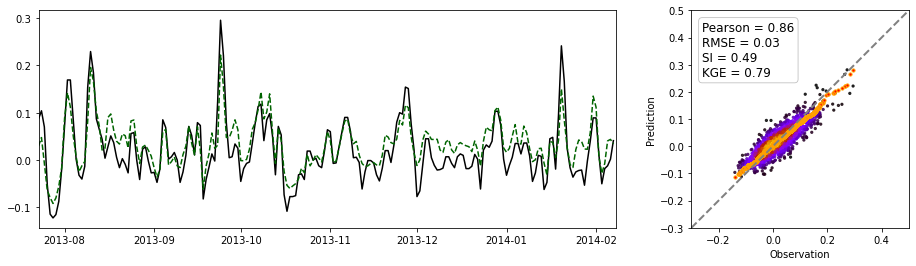

 93% (14 of 15) |######################  | Elapsed Time: 0:00:07 ETA:   0:00:00

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.86, 0.73)
 NSE = [0.73149413], KGE = [0.78724491] and KGE_PRIME = [0.77809516]
 R score: 0.73 -- in TEST data

 26 PCs (0.95 expl. variance) will be used to train the model!! 



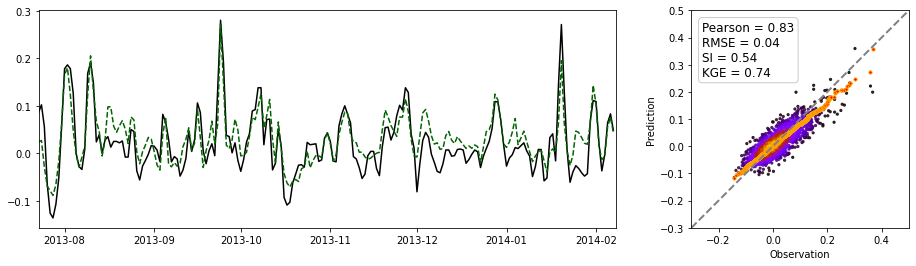

100% (15 of 15) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68228697], KGE = [0.74109016] and KGE_PRIME = [0.77910606]
 R score: 0.68 -- in TEST data


In [13]:
run = True
if run:
    # perform the Multilinear-Regression (regional)
    metrics_regional = [] # save regional metrics
    pcs_to_use_regional = [] # save used pcs (f-regression)
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )[::100]
    # perform the MultiLinear regression over all the sites
    for site in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)
        metrics, model, pcs_to_use = MultiLinear_Regression(
            pcs_data_regional, ss_moana, # use default attributes
            verbose=True, plot_results=True
        ) # using the regional-pre-loaded pcs
        metrics_regional.append(list(metrics.values())) # save site metrics
        pcs_to_use_regional.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_regional = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_regional[metric] = (('site'),np.array(metrics_regional)[:,im])
    sites_metrics_regional['latitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    sites_metrics_regional['longitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the metrics
    metrics_dataset_regional = xr.Dataset(
        sites_metrics_regional,coords={'site':sites_regional}
    )
    # local copys
    if False:
        metrics_dataset_regional.to_netcdf(
            data_path+'/statistics/regional_models/stats_lm_regional_daily.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/regional_models/pcs_lm_regional_daily.npy',
            np.array(pcs_to_use_regional)
        ) # save pcs used in the linear regressions
else:
    metrics_dataset_regional = xr.open_dataset(
        data_path+'/statistics/regional_models/stats_lm_regional_daily.nc'
    )

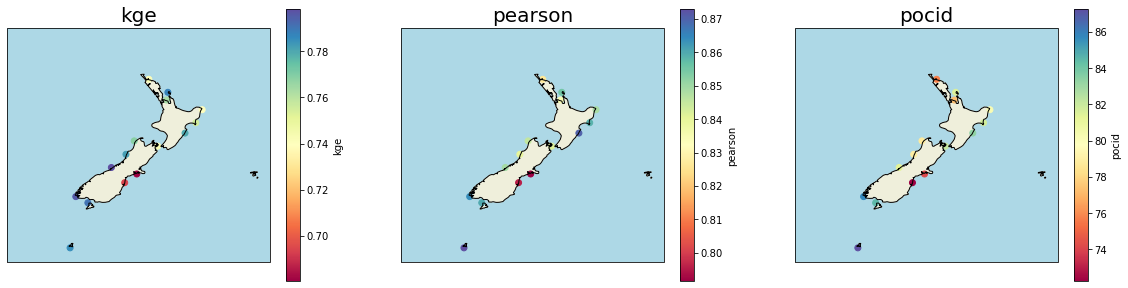

In [15]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_regional.astype(float),
               plot_stats=['kge','pearson','pocid'],
               cmap='Spectral')

with the code below, we can plot the PCs used with the linear regression:

```python
    pcs_to_use_regional = np.load(
        data_path+'/statistics/regional_models/pcs_lm_regional_daily.npy',
        allow_pickle=True
    )
    max_pcs = max([np.max(array) for array in pcs_to_use_regional])
    pcs_importance = np.zeros((len(pcs_to_use_regional),max_pcs))
    for i,array in enumerate(pcs_to_use_regional):
        for pc in range(max_pcs):
            try:
                pcs_importance[i,pc] = (max_pcs-np.where(array==pc)[0])/max_pcs
            except:
                continue
    fig, ax = plt.subplots(figsize=(20,10))
    pcol = ax.pcolor(pcs_importance.T[:50,:],cmap='Spectral')x
    fig.colorbar(pcol)
    # ax.set_yticks(np.arange(0,50,5)+0.5)
    # ax.set_yticklabels(np.arange(0,50,5)+1,fontsize=16)
    # ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
    # ax.set_xticklabels(np.arange(
    #     20,len(load_cfsr_moana_uhslc.predictand.site.values),1
    # )[::50],fontsize=16)
    # plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
    plt.show()
```

```{tip}
Images generated by code, as the one above, can be easily open in a new window with the right click, as they have all been generated with good quality for this particular purpose!!
```

## Linear regression in the UHSLC tidal gauges + validation

Here, we really use for the first time our "validators", which are the main truth in the project. In coastal engineering, we usually use the buoys (if we are working with waves) and the tidal gauges (water elevation) as the real observations, and once they are processed, which is the case of these nodes shown here, they might be used as the data to validate with.

Below, apart from plotting the location of the different tidal gauges that we will be working with, we show how the linear regression with the regional predictor behaves in the nearest locations to the tidal gauges, and how this pre-trained linear regression model performs in that tidal gauge too.

To understand how good or bad the linear model might behave when predicting the storm surge of the tidal guages, we find the answer in the validations we performed in the first notebook, called **Data visualization and validation (data_visualization.ipynb)**, where the comparison of all the tidal gauges and the nearest moana nodes is shown.

```{warning}
This use of the pre-trained linear model with the moana nodes for the tidal gauges must be revised, as the distances between both locations might involve the appearance of new physical phenomena!! Moreover, model is calibrated with the hindcast, not with the TGs!!
```

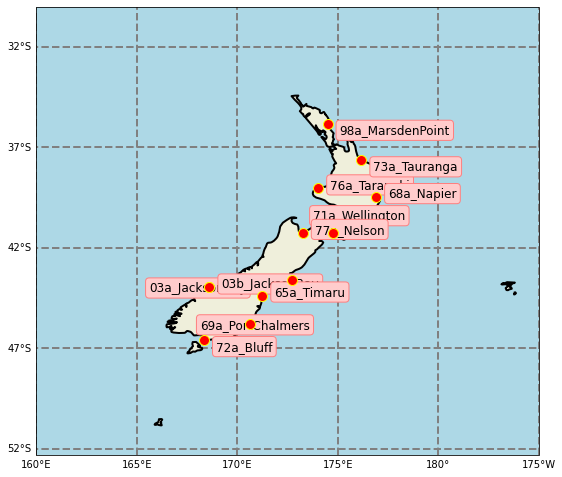

In [16]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)

```{note}
In this analysis, we use a local predictor with the projected winds, focused in the location studied
```

FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_689_winds_gradients_1D_tl3.nc


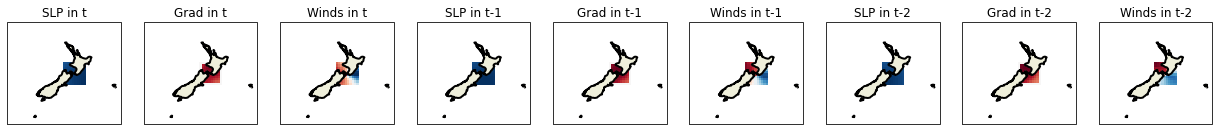

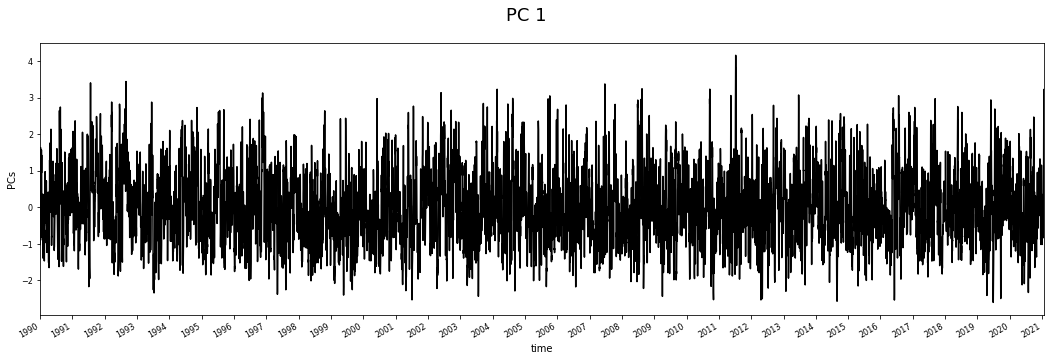


 21 PCs (0.98 expl. variance) will be used to train the model!! 



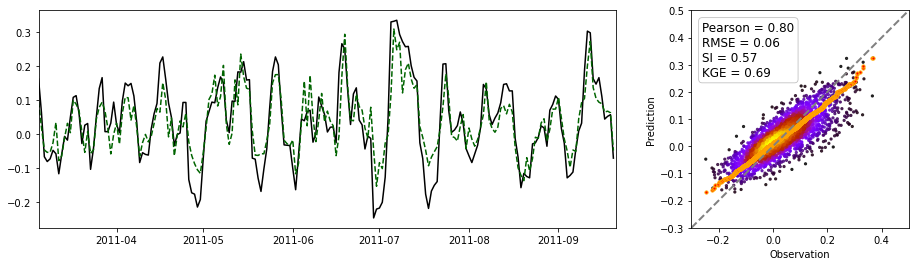

Data comparison is   --   BIAS: -0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 NSE = [0.63671411], KGE = [0.68927323] and KGE_PRIME = [0.68009402]
 R score: 0.64 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_328_winds_gradients_1D_tl3.nc


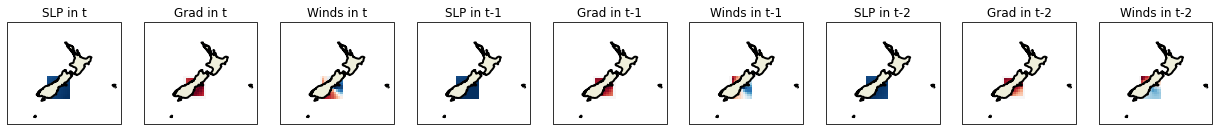

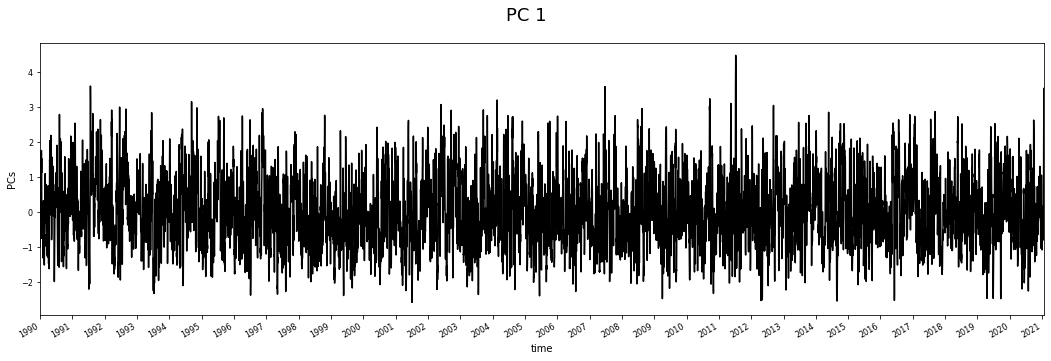


 22 PCs (0.98 expl. variance) will be used to train the model!! 



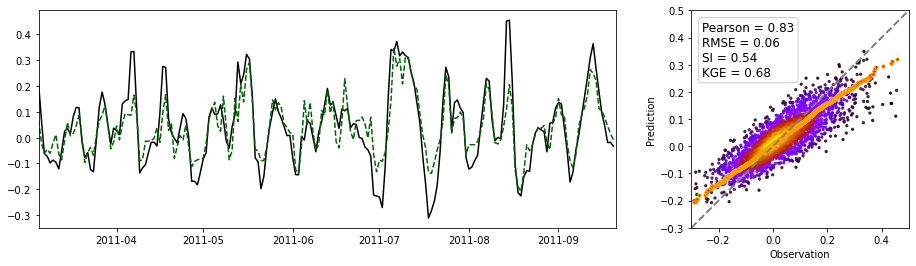

Data comparison is   --   BIAS: 0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.83, 0.68)
 NSE = [0.68355969], KGE = [0.68430639] and KGE_PRIME = [0.71762063]
 R score: 0.68 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_393_winds_gradients_1D_tl3.nc


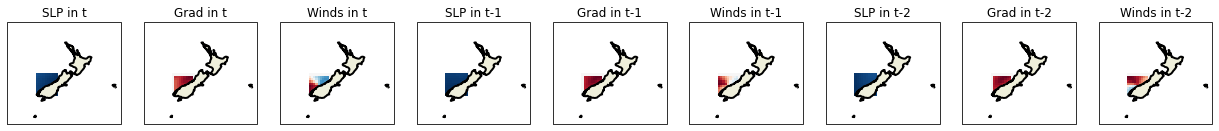

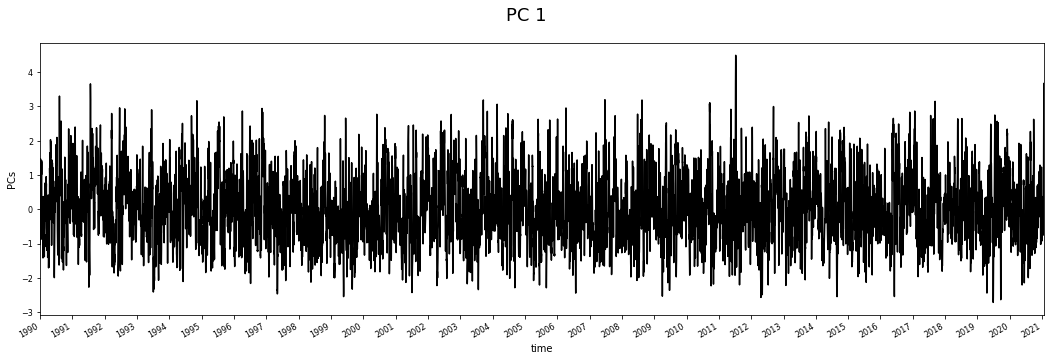


 19 PCs (0.98 expl. variance) will be used to train the model!! 



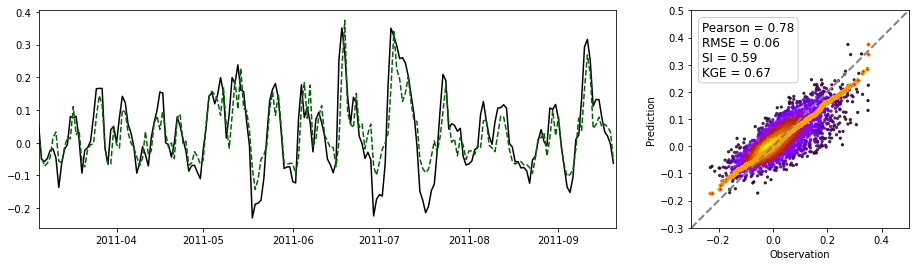

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61423934], KGE = [0.674946] and KGE_PRIME = [0.72664175]
 R score: 0.61 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_1327_winds_gradients_1D_tl3.nc


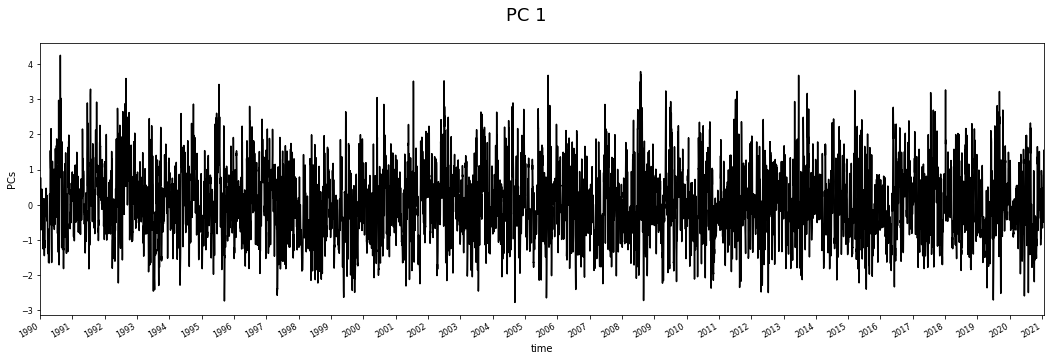


 18 PCs (0.98 expl. variance) will be used to train the model!! 



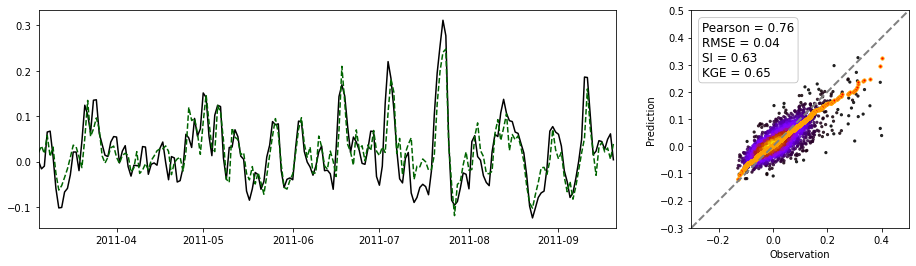

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.57)
 NSE = [0.5705238], KGE = [0.65300573] and KGE_PRIME = [0.66028484]
 R score: 0.57 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_393_winds_gradients_1D_tl3.nc


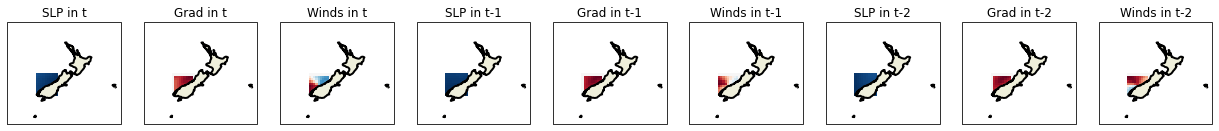

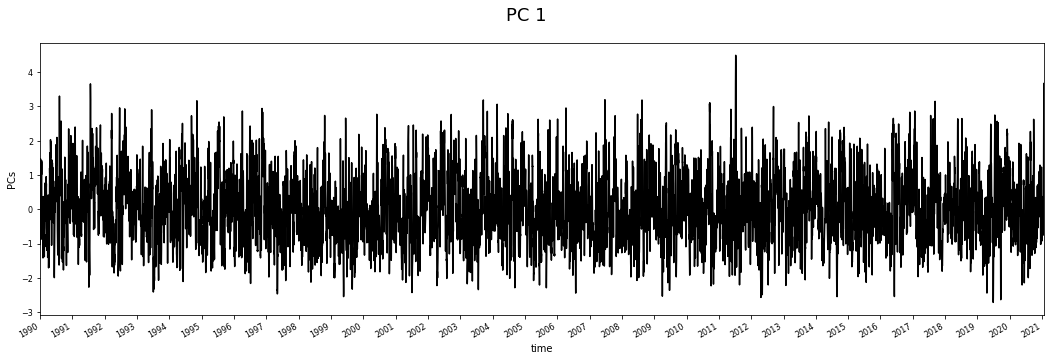


 19 PCs (0.98 expl. variance) will be used to train the model!! 



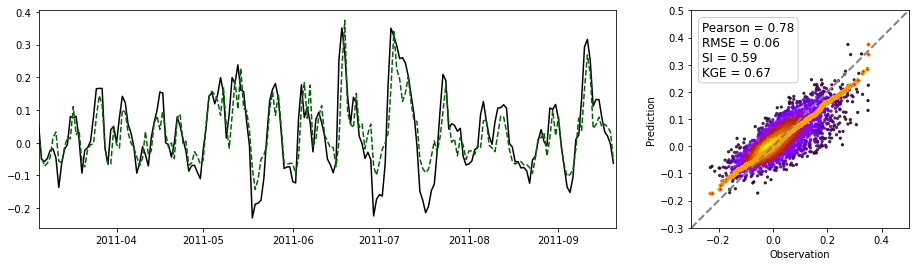

Data comparison is   --   BIAS: 0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.61)
 NSE = [0.61423934], KGE = [0.674946] and KGE_PRIME = [0.72664175]
 R score: 0.61 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_480_winds_gradients_1D_tl3.nc


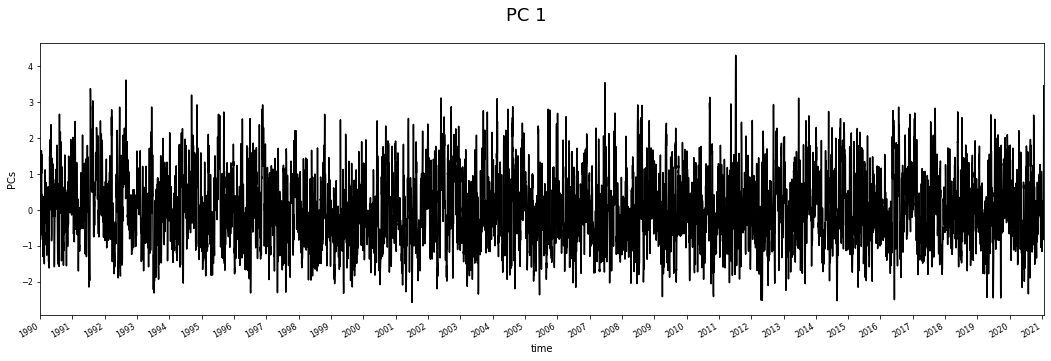


 23 PCs (0.98 expl. variance) will be used to train the model!! 



Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66732828], KGE = [0.67763433] and KGE_PRIME = [0.71683116]
 R score: 0.67 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_999_winds_gradients_1D_tl3.nc


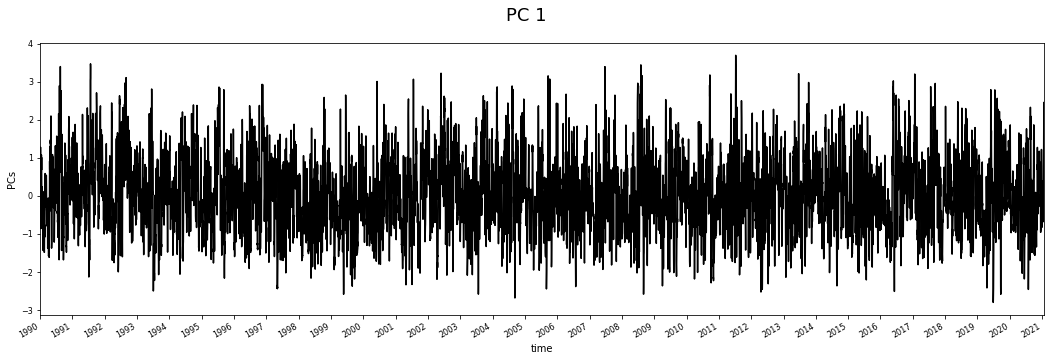


 21 PCs (0.98 expl. variance) will be used to train the model!! 



Data comparison is   --   BIAS: 0.00, SI: 0.56, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 NSE = [0.66196146], KGE = [0.69714722] and KGE_PRIME = [0.74234863]
 R score: 0.66 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_116_winds_gradients_1D_tl3.nc


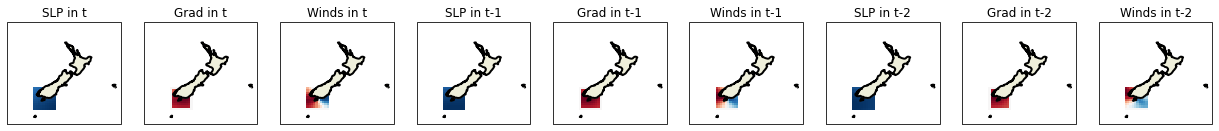

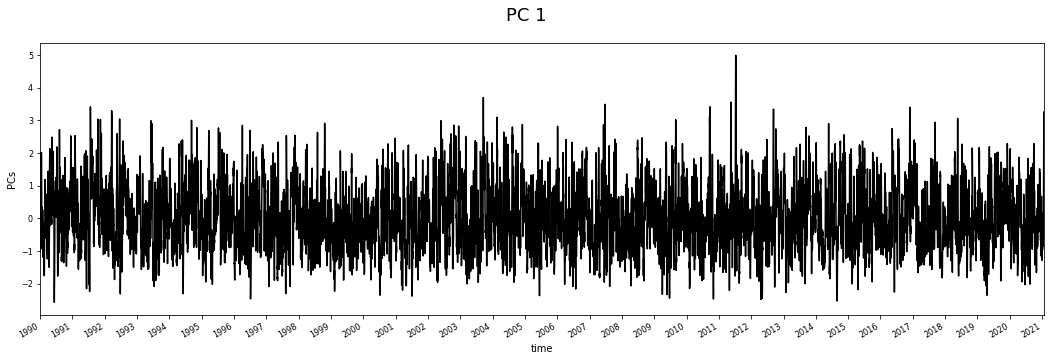


 15 PCs (0.98 expl. variance) will be used to train the model!! 



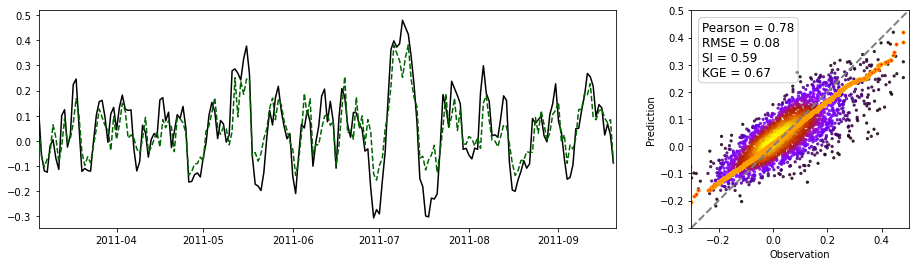

Data comparison is   --   BIAS: -0.00, SI: 0.59, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.78, 0.60)
 NSE = [0.60181932], KGE = [0.66675965] and KGE_PRIME = [0.65999301]
 R score: 0.6 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_224_winds_gradients_1D_tl3.nc


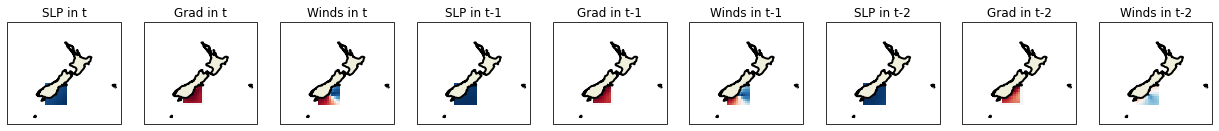


 18 PCs (0.98 expl. variance) will be used to train the model!! 



Data comparison is   --   BIAS: 0.00, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 NSE = [0.66967715], KGE = [0.71035638] and KGE_PRIME = [0.72571431]
 R score: 0.67 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_1124_winds_gradients_1D_tl3.nc


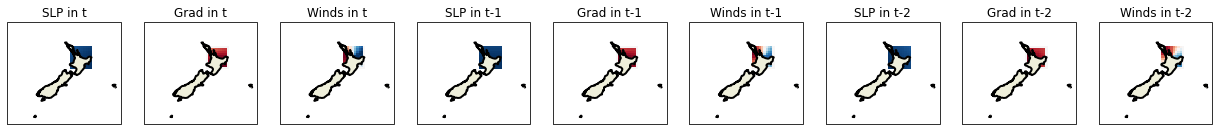

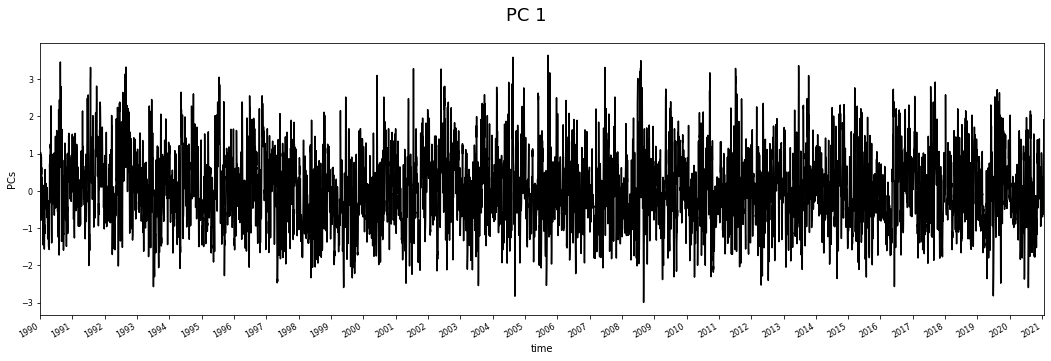


 21 PCs (0.98 expl. variance) will be used to train the model!! 



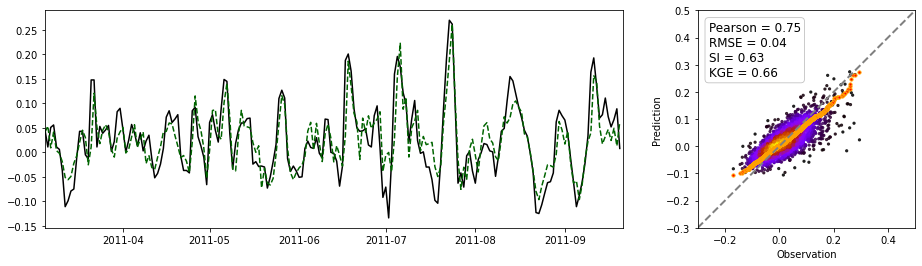

Data comparison is   --   BIAS: 0.00, SI: 0.63, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.75, 0.56)
 NSE = [0.55604869], KGE = [0.65868618] and KGE_PRIME = [0.66443301]
 R score: 0.56 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_949_winds_gradients_1D_tl3.nc


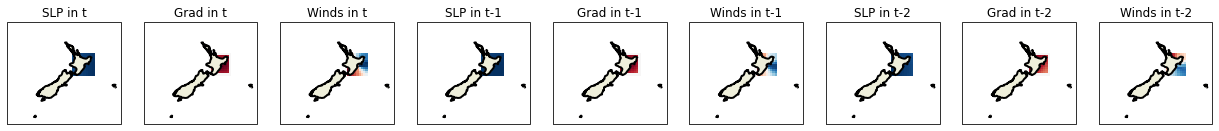

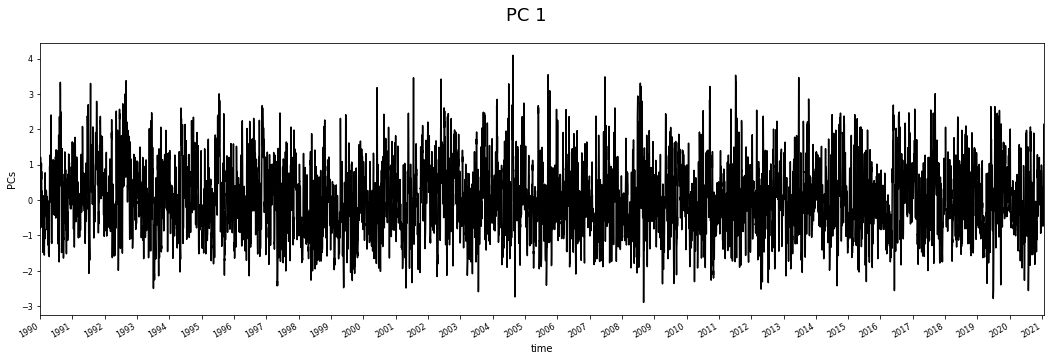


 23 PCs (0.98 expl. variance) will be used to train the model!! 



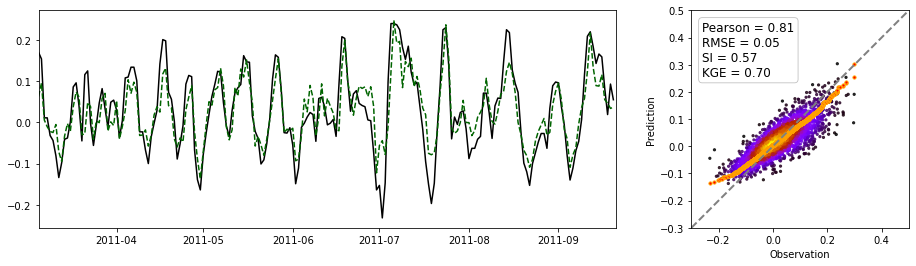

Data comparison is   --   BIAS: 0.00, SI: 0.57, Relative - RMSE: 0.29
 and Correlations (Pearson, Rscore): (0.81, 0.65)
 NSE = [0.64968726], KGE = [0.69825698] and KGE_PRIME = [0.71730566]
 R score: 0.65 -- in TEST data
FILE /Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/local_2.5_2.5_708_winds_gradients_1D_tl3.nc


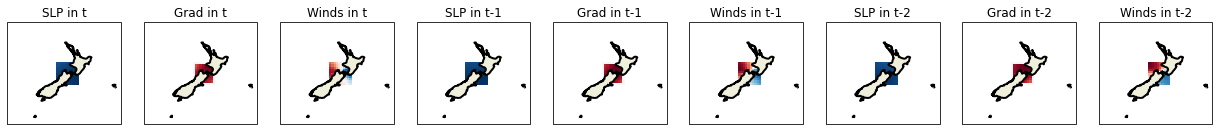

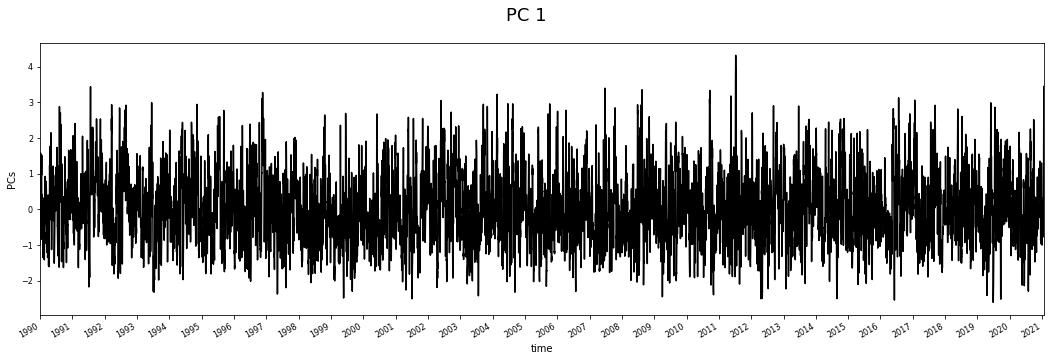


 26 PCs (0.98 expl. variance) will be used to train the model!! 



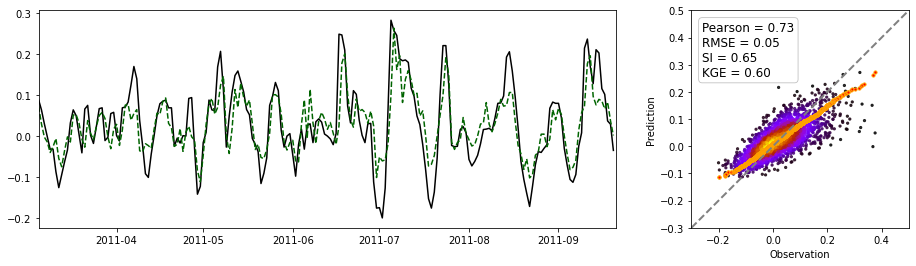

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.73, 0.53)
 NSE = [0.53405327], KGE = [0.60226344] and KGE_PRIME = [0.59854972]
 R score: 0.53 -- in TEST data


In [21]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)
    metrics, model, pcs_to_use = MultiLinear_Regression(
        PCA_DynamicPred(
            load_cfsr_moana_uhslc.predictor_slp.SLP, 
            calculate_gradient=True, time_lapse=3,
            wind=load_cfsr_moana_uhslc.predictor_wind,
            site_location=(ss_moana.lon.values,ss_moana.lat.values),
            region=(True, (
                ss_moana.lon.values-2.5,
                ss_moana.lon.values+2.5,
                ss_moana.lat.values-2.5,
                ss_moana.lat.values+2.5
            )),
            site_id=stat,
            pcs_folder='/Users/administrador/Documents/geocean-nz-ss/data/calculated_pcs/',
            pca_plot=(True,False,1), verbose=False,
            pca_ttls=['SLP in t','Grad in t','Winds in t',
                      'SLP in t-1','Grad in t-1','Winds in t-1',
                      'SLP in t-2','Grad in t-2','Winds in t-2']
            ).pcs_get()[0],
        ss_moana, percentage_PCs=0.98, plot_results=True, verbose=True,
        model_metrics=default_evaluation_metrics, train_size=0.7,
        # validator=(
        #     True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        # )
)